#Arctic freshwater analysis

In [1]:
import glob
import scipy.io
import datetime
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
% matplotlib inline

In [2]:
RB=[0.25, 0.41, 0.88]    # Royal blue
AM=[0.90, 0.17, 0.31]    # Amathran
CamB = [0.64, 0.76, 0.68]# Cambridge blue

$$
FWC = \int^{0}_{z_{lim}}{\left( 1-\frac{S(z)}{S_{ref}} \right)dz}
$$

* $S_{ref}$ is 34.8 as the end-member of Atlantic water
* $S(z)$ is the salinity profile as a function of $z$
* $z_{lim}$ first level of $S\left(z_{lim}\right) \geq S_{ref}$

In [3]:
def fwc_1d(S, z, Sref):
    if S[0] < Sref:
        id_lim = np.searchsorted(S, Sref, 'left')
        fun = 1-S[:id_lim]/Sref
        return np.trapz(fun, x=z[:id_lim])
    else:
        return np.nan
def fwc_2d(S, z, Sref):
    fwc = np.empty(S.shape)[0, :, :]
    for i in range(np.size(S, 1)):
        for j in range(np.size(S, 2)):
            fwc[i, j] = fwc_1d(S[:, i, j], z, Sref)
    return fwc

# WOA 1996 - 2005 Climatology

In [6]:
JJA_name=glob.glob('_data/Reanalysis/WOA/*s13*.nc')
DJF_name=glob.glob('_data/Reanalysis/WOA/*s15*.nc')

found file: 
['_data/Reanalysis/WOA\\woa13_95A4_s13_01.nc']
found file: 
['_data/Reanalysis/WOA\\woa13_95A4_s15_01.nc']


In [7]:
JJA_obj=nc.Dataset(JJA_name[0])
DJF_obj=nc.Dataset(DJF_name[0])
print('Variables in {}:\n==============================================\n{}'.format(JJA_name[0], JJA_obj.variables.keys()))

Variables in _data/Reanalysis/WOA\woa13_95A4_s13_01.nc:
[u'crs', u'lat', u'lat_bnds', u'lon', u'lon_bnds', u'depth', u'depth_bnds', u'time', u'climatology_bounds', u's_an', u's_mn', u's_dd', u's_sd', u's_se', u's_oa', u's_ma', u's_gp']


In [8]:
lon=JJA_obj.variables['lon'][:]
lat=JJA_obj.variables['lat'][:]
JJA=JJA_obj.variables['s_an'][:]
DJF=DJF_obj.variables['s_an'][:]
depth=JJA_obj.variables['depth'][:]
longitude, latitude = np.meshgrid(lon, lat)

In [29]:
longitude.shape

(180L, 360L)

In [25]:
fwc_JJA = fwc_2d(JJA[0, :, :, :], depth, 34.8)
fwc_DJF = fwc_2d(DJF[0, :, :, :], depth, 34.8)

In [26]:
fwc_JJA_mask = np.ma.masked_where(np.isnan(fwc_JJA), fwc_JJA)
fwc_DJF_mask = np.ma.masked_where(np.isnan(fwc_DJF), fwc_DJF)

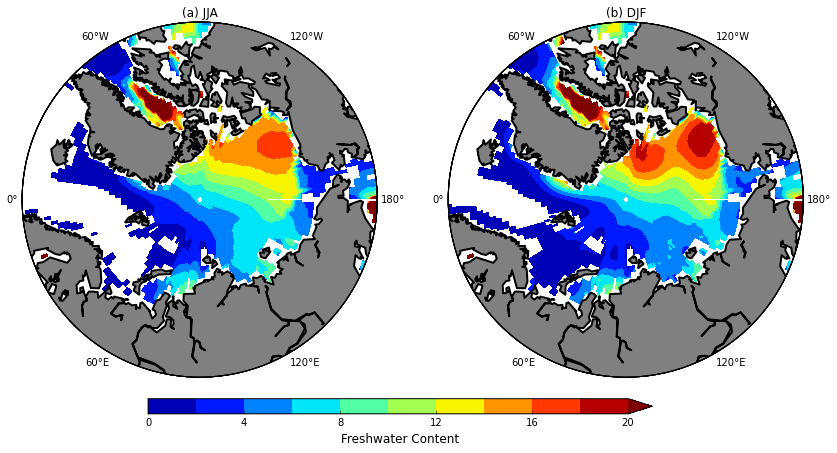

In [28]:
fig = plt.figure(figsize=(14, 14))
ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)

proj=Basemap(projection='npstere', resolution='c', boundinglat=60, lon_0=90, round=True, ax=ax1)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=2.0, linestyle='-', color='k')
x, y=proj(longitude, latitude)
CS = proj.contourf(x, y, fwc_JJA_mask, range(0, 22, 2), extend='max')
ax1.set_title('(a) JJA')

ax = fig.gca()
proj=Basemap(projection='npstere', resolution='c', boundinglat=60, lon_0=90, round=True, ax=ax2)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=2.0, linestyle='-', color='k')
x, y=proj(longitude, latitude)
CS = proj.contourf(x, y, fwc_DJF_mask, range(0, 22, 2), extend='max')
ax2.set_title('(b) DJF')

cax  = fig.add_axes([0.25, 0.3, 0.5, 0.015])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('Freshwater Content (m)', fontsize=12)

# ORAS4 1958-2014 monthly mean

<img src="_figures/ORAS4.PNG" width=550 align="left"/>

In [4]:
from dateutil.relativedelta import relativedelta

In [7]:
names=glob.glob('_data\Reanalysis\ECMWF\ORAS4\*.nc')
name_share = names[0]
NUM = len(names)

In [8]:
date_list = []
year_list = []
base = datetime.datetime(1958, 1, 1)
date_list += [base + relativedelta(months=x) for x in range(0, NUM*12, 1)]
year_list += [base + relativedelta(years=x) for x in range(0, NUM, 1)]

In [9]:
share_obj = nc.Dataset(name_share)
x = share_obj.variables['lon'][:]
y = share_obj.variables['lat'][:]
depth = share_obj.variables['depth'][:]
longitude, latitude = np.meshgrid(x, y)

In [10]:
#fwc = np.empty([NUM*12, 23, 360])
#fwc_temp = np.empty([12, 23, 360])
#for i in range(NUM):
#    temp_obj = nc.Dataset(names[i])
#    salin = temp_obj.variables['so'][:]
#    salin = salin[:, :, 156:-1, :]
#    print('File {}').format(i+1) # <-------- File
#    for j in range(12):
#        fwc_temp[j] = fwc_2d(salin[j, :, :, :], depth, 34.8)
#        print('\tMonth {}').format(j+1) # <- Month
#    fwc[i*12:(i+1)*12, :, :] = fwc_temp

In [11]:
#scipy.io.savemat('ORAS4_fwc.mat', mdict={'fwc':fwc})

In [32]:
MAT=scipy.io.loadmat('ORAS4_fwc.mat')
fwc = MAT['fwc'][:]

## Beaufort Gyre FWC Series

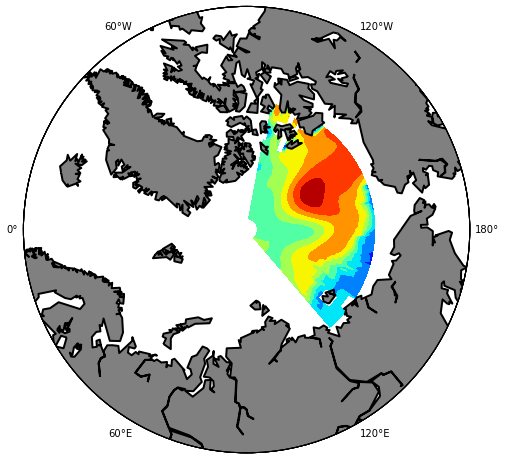

In [88]:
test = fwc[200, :, :]
test[:, 0:130]=np.nan; test[:, 260:-1]=np.nan
test[0:6, :]=np.nan
fig = plt.figure(figsize=(8, 8)); ax = fig.gca()
proj=Basemap(projection='npstere', resolution='c', boundinglat=60, lon_0=90, round=True, ax=ax)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=2.0, linestyle='-', color='k')
x, y=proj(longitude[156:-1, :], latitude[156:-1, :])
CS = proj.contourf(x, y, test, range(0, 22, 2), extend='max')

In [48]:
MAT = scipy.io.loadmat('_data\Reanalysis\ECMWF\ORAS4\AO_NOAA.mat')
AO = MAT['AO'][:]

In [97]:
fwc_mean = np.nanmean(np.nanmean(fwc[:, 6:-1, 130:260], 1), 1)

In [165]:
fwc_annual = np.empty(NUM)
fwc_upper = np.empty(NUM)
fwc_lower = np.empty(NUM)
AO_annual = np.empty(NUM)
for i in range(NUM):
    fwc_annual[i] = np.mean(fwc_mean[i*12:(i+1)*12])
    fwc_upper[i] = np.max(fwc_mean[i*12:(i+1)*12])
    fwc_lower[i] = np.min(fwc_mean[i*12:(i+1)*12])
    AO_annual[i] = np.mean(AO[i*12:(i+1)*12, 2])

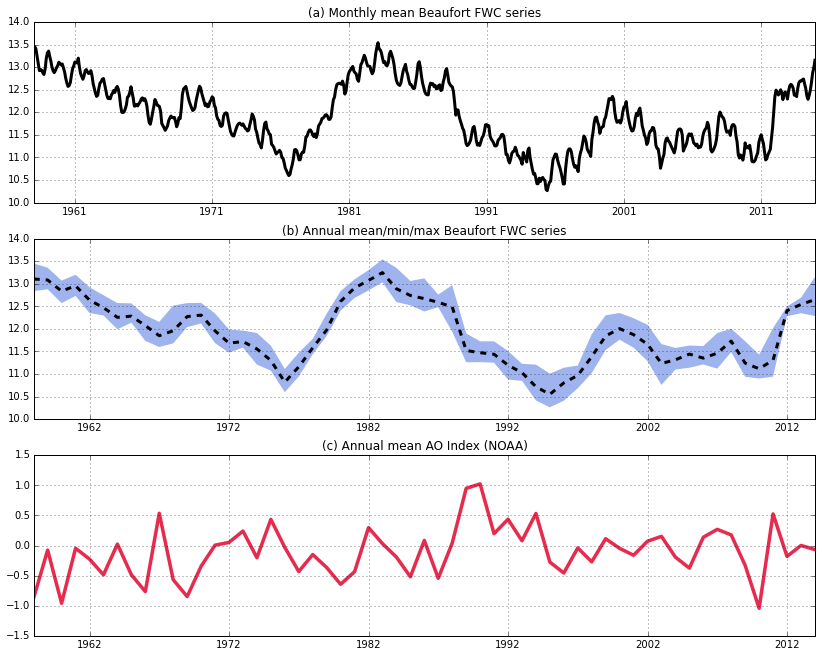

In [174]:
fig = plt.figure(figsize=(14, 11))
ax1 = plt.subplot2grid((3, 1), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((3, 1), (1, 0), colspan=1, rowspan=1)
ax3 = plt.subplot2grid((3, 1), (2, 0), colspan=1, rowspan=1)
ax1.plot(date_list, fwc_mean, color='k', lw=3)
ax2.plot(year_list, fwc_annual, color='k', lw=3, ls='--')
ax2.fill_between(year_list, fwc_upper, fwc_lower, where=fwc_upper>=fwc_lower, facecolor=RB, interpolate=True, linewidth=0.0, alpha=0.5)
ax3.plot(year_list, AO_annual, color=AM, lw=3.5)
ax2.grid(); ax1.grid(); ax3.grid()
ax1.set_title('(a) Monthly mean Beaufort FWC series')
ax2.set_title('(b) Annual mean/min/max Beaufort FWC series')
ax3.set_title('(c) Annual mean AO Index (NOAA)')

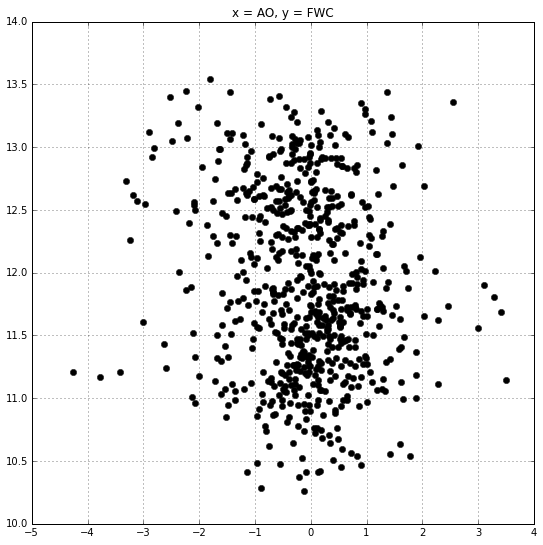

In [175]:
fig = plt.figure(figsize=(9, 9))
ax = fig.gca(); ax.grid()
ax.plot(AO[:, 2], fwc_mean, 'ko')
ax.set_title('x = AO, y = FWC')

## EOF Decomposition of FWC in pan-Arctic

In [13]:
def EOF(H, nmode=10, ndim=3, reverse=1):
    '''
    Converted from MATLAB to Python 2.7 code @ 2015/06/15 - YKS
     + ndim: [LAT, LON, TIME] data (=3) or [MAP, TIME] data (=2)
     + reverse: normalized spatial pattern (=0), normalized PC (=1)
    % ======================================================================= %
    % Input
    %   H: Variable required for EOF comutation, H(LAT, LON, Time) 
    %       or H(Space, Time) is accepted.
    %   nmode: Number of modes output
    % Output
    %   EOFs: EOF Spatial Pattern
    %   PC: Timeseries cooresponding to each EOFs
    %   expvar: Explained variance
    % ======================================================================= %
    % Author
    %   Yingkai Sha
    %       yingkaisha@gmail.com
    % 2014/3/18
    % ======================================================================= %
    '''
    ##import scipy.linalg.eig as eig
    # Get the size of array
    if ndim == 3:
        LAT, LON, T = H.shape
    elif ndim == 2:
        LON, T = H.shape
        LAT = 1
    # Covarience
    H = np.reshape(H, [LAT*LON, T]).T
    R=np.dot(H, H.T); N = np.size(R, 0)
    # Allocation
    PC     = np.zeros([nmode, T]);
    expvar = np.zeros([nmode]);
    eof    = np.zeros([N, LAT*LON]);
    EOFs   = np.zeros([LAT, LON, nmode]);
    # Eigvector analysis
    L, E = np.linalg.eig(R)
    # Get modes
    E    = np.dot(H.T, E)
    #sq   = (np.sqrt(np.diag(L))).T
    #sq   = sq[0, :]
    sq = np.sqrt(L)
    E    = E/sq
    Z    = np.dot(E.T, H.T)
    for i in range(nmode):
        eof[i, :] = np.squeeze(E[:, i]).T
        PC[i, :]  = np.squeeze(Z[i, :])
    # Get expvar
    L = np.abs(L)
    dsum = np.sum(np.abs(L))
    # Output
    for i in range(nmode):
        expvar[i] = L[i]/dsum
        EOFs[:, :, i] = np.reshape(eof[i, :], [LAT, LON])
    if reverse==1:
        EOFs, PC = reverse_std(EOFs, PC, nmode)
    return EOFs, PC, expvar

def reverse_std(EOFs, PC, nmode):
    for i in range(nmode):
        STD = np.nanstd(PC[i, :])
        PC[i, :] = PC[i, :]/STD
        EOFs[:, :, i] = EOFs[:, :, i]*STD
    return EOFs, PC

In [14]:
def seasonal_decomp(data, method=0):
    '''
    =======================================================================
    Remove the seasonal cycle from 1D data
                            ----- created on 2015/06/15, Yingkai (Kyle) Sha
    -----------------------------------------------------------------------
        data = seasonal_decomp(...)
    -----------------------------------------------------------------------
    Input:
            data
            method: removal done by anomaly (=0) or normalize (=1)
    ======================================================================= 
    '''
    for mon in range(12):
        temp_data = data[mon:len(data):12]
        if method == 0:
            data[mon:len(data):12] = data[mon:len(data):12]-np.nanmean(temp_data)
        elif method == 1:
            data[mon:len(data):12] = (data[mon:len(data):12]-np.nanmean(temp_data))/np.nanstd(temp_data)
    return data 
def seasonal_decomp3d(data, method=0):
    '''
    =======================================================================
    Remove the seasonal cycle from 3D data
                            ----- created on 2015/06/15, Yingkai (Kyle) Sha
    -----------------------------------------------------------------------
        data = seasonal_decomp(...)
    -----------------------------------------------------------------------
    Input:
            data
            method: removal done by anomaly (=0) or normalize (=1)
    ======================================================================= 
    '''
    for i in range(np.size(data, 0)):
        for j in range(np.size(data, 1)):
            data[i, j, :] = seasonal_decomp(data[i, j, :], method=0)
    return data

In [19]:
def draw_smode(lon, lat, EOFs, clevs, num, ax):
    proj=Basemap(projection='npstere', resolution='l', boundinglat=66.5, lon_0=90, round=True, area_thresh=5e4, ax=ax)
    proj.drawparallels(np.arange(-90, 90, 15), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
    proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0.5)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(lon, lat)
    CS = proj.contourf(x, y, EOFs[:, :, num], clevs, cmap=plt.cm.bwr, extend='both')
    proj.contour(x, y, EOFs[:, :, num], clevs, colors='gray', linewidths=1.5)
    proj.contour(x, y, EOFs[:, :, num], [-0.5, 0.5], colors='k', linewidths=2.5)
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.75, 0.90, "Exp. var.: %.2f"%expvar[num], transform=ax.transAxes, \
        fontsize=10, verticalalignment='top', bbox=props)
    return CS

In [33]:
fwc_a = np.copy(fwc)
fwc_a[np.isnan(fwc_a)]=0.0
fwc_a = np.transpose(fwc_a, [1, 2, 0])
fwc_a = seasonal_decomp3d(fwc_a, method=0)

In [35]:
EOFs, PC, expvar = EOF(fwc_a, nmode=10, ndim=3, reverse=1)

F:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
F:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:48: ComplexWarning: Casting complex values to real discards the imaginary part


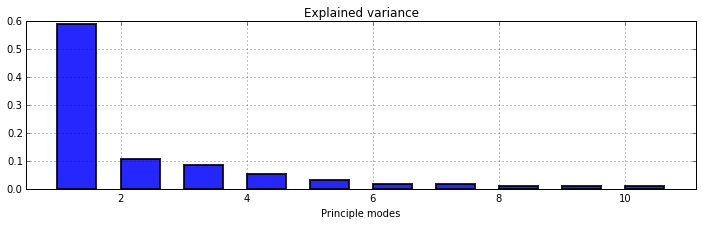

In [36]:
fig=plt.figure(figsize=(12, 3))
ax=plt.gca(); ax.grid(); ax.set_xlim(0.5, 11.118)
ax.bar(np.arange(1, 11), expvar, width=0.618, lw=2, alpha=0.85)
ax.set_xlabel('Principle modes')
ax.set_title('Explained variance', fontsize=12)

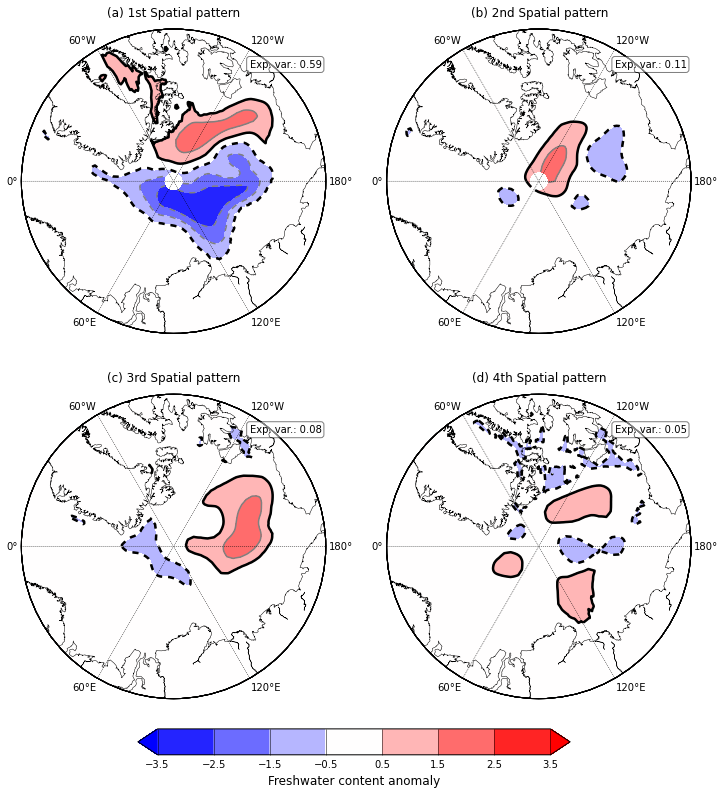

In [44]:
clevs = np.arange(-3.5, 4.5, 1)
#
fig = plt.figure(figsize=(12, 12))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=1)
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
ax4 = plt.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1)
#
CS = \
draw_smode(longitude[156:-1, :], latitude[156:-1, :], EOFs, clevs, 0, ax1)
ax1.set_title('(a) 1st Spatial pattern', y=1.025)
draw_smode(longitude[156:-1, :], latitude[156:-1, :], EOFs, clevs, 1, ax2)
ax2.set_title('(b) 2nd Spatial pattern', y=1.025)
draw_smode(longitude[156:-1, :], latitude[156:-1, :], EOFs, clevs, 2, ax3)
ax3.set_title('(c) 3rd Spatial pattern', y=1.025)
draw_smode(longitude[156:-1, :], latitude[156:-1, :], EOFs, clevs, 3, ax4)
ax4.set_title('(d) 4th Spatial pattern', y=1.025)
# bottom colorbar
cax  = fig.add_axes([0.26, 0.06, 0.5, 0.03])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('Freshwater content anomaly', fontsize=12)
CBar.ax.tick_params(axis='x', length=26)
CBar.set_ticks(clevs)

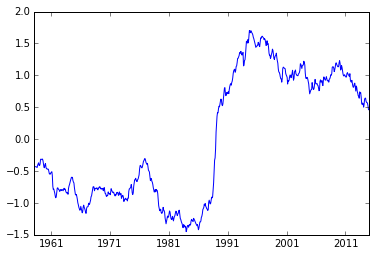

In [53]:
plt.plot(date_list, PC[0, :])

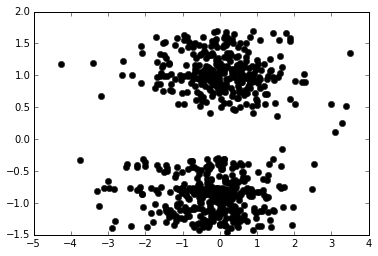

In [51]:
plt.plot(AO[:, 2], PC[0, :], 'ko')